# Porosity analysis

This notebook is developed for the course 02509, week 6. The notebook runs on Google colab, and the students should have it running on the DTU G-bar cluster.

## Running the notebook on G-bar

(Not tested!)
* Log on G-bar using ThinLinc client
* Copy the notebook to a folder you have access to
* Open the terminal (Applications -> System -> Terminal)
* Start course node `02509sh -X` or another node, e.g. `linuxsh -X`
* Navigate to `/dtu/3d-imaging-center/courses`
* Launch initialization script `. conda/conda-init.sh` or `source conda/conda-init.sh`
* Activate the environment `conda activate env-02509`
* Navigate to the folder where you placed the notebook
* Start notebook `jupyter-notebook`

Furthermore, if you are at DTU G-bar, you don't need to retrieve the data, instead find data in following directories:
```
'/dtu/3d-imaging-center/courses/02509/data/' 
```


In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import tifffile
import skimage.filters
import skimage.measure
import scipy


def random_colors(N):
    '''Colormap with randomly permuted jet colors.'''
    colors = plt.cm.jet(np.linspace(0, 1, N))
    colors = np.random.permutation(colors)
    colors = np.vstack((np.array([0.5, 0.5, 0.5, 1]), colors))
    cmap = matplotlib.colors.ListedColormap(colors)
    return cmap


In [2]:
# If needed, retrieve volume from QIM data repository. 
# This may take a couple of minutes, but is only done once.
import os
if not os.path.isdir('cement_data'):
    !wget -q https://qim.compute.dtu.dk/data-repository/cement_data.zip

    # Unzip the file to the current directory.
    import shutil
    shutil.unpack_archive('cement_data.zip', 'cement_data')

In [3]:
# Load data.
vol = tifffile.imread('cement_data/cement2.tif')
Z, Y, X = vol.shape
dtype = vol.dtype
print(f'Tiff file has {Z} slices of shape ({Y}, {X}). Data type is {dtype}.')

# Crop a smaller part of the data.
vol = vol[300:500, 200:400, 300:500]
Z, Y, X = vol.shape
print(f'Tiff file has {Z} slices of shape ({Y}, {X}). Data type is {dtype}.')

Tiff file has 800 slices of shape (800, 800). Data type is uint8.
Tiff file has 200 slices of shape (200, 200). Data type is uint8.


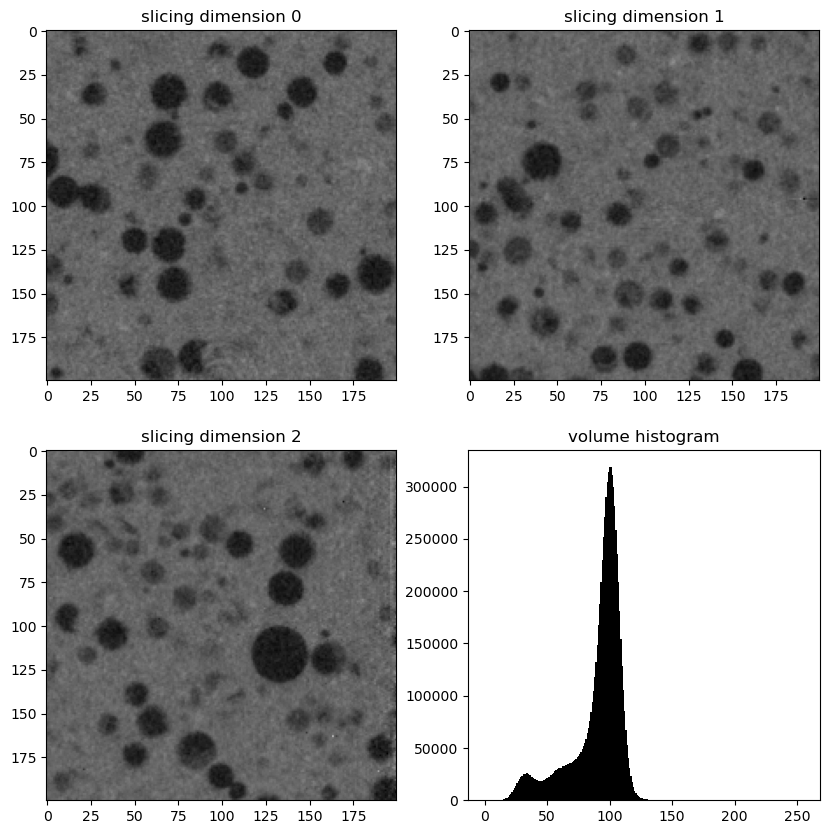

In [5]:
# Look at three orthogonal cross-sections and histogram.

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
ax[0].imshow(vol[Z//2], cmap=plt.cm.gray, vmin=0, vmax=255)
ax[0].set_title('slicing dimension 0')
ax[1].imshow(vol[:, Y//2, :], cmap=plt.cm.gray, vmin=0, vmax=255)
ax[1].set_title('slicing dimension 1')
ax[2].imshow(vol[:, :, X//2], cmap=plt.cm.gray, vmin=0, vmax=255)
ax[2].set_title('slicing dimension 2')
edges = np.arange(257)-0.5
centers = np.arange(256)
hist = np.histogram(vol.ravel(), edges)[0]
ax[3].bar(centers, hist, width=1, color='k')
ax[3].set_title('volume histogram')
plt.show()


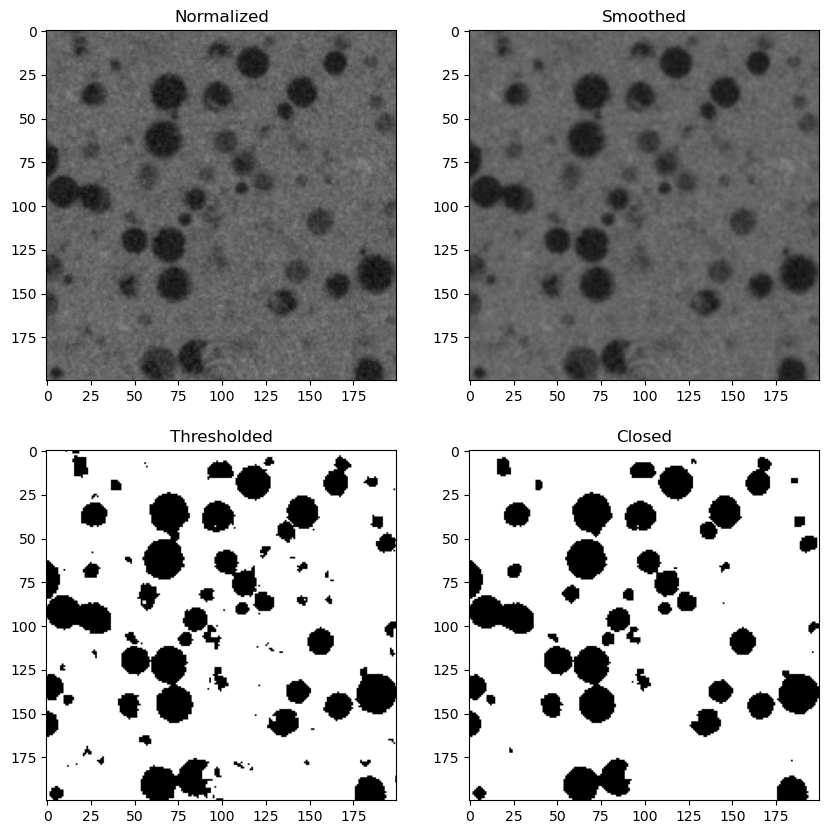

In [6]:
# Binarize the volume and visualize all processing steps on one slice.

bin_vol = vol

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

bin_vol = bin_vol.astype(float)/255
ax[0].imshow(bin_vol[Z//2, ], cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_title('Normalized')

bin_vol = skimage.filters.gaussian(bin_vol, sigma=0.5)
ax[1].imshow(bin_vol[Z//2], cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_title('Smoothed')

bin_vol = bin_vol > 80/255
ax[2].imshow(bin_vol[Z//2], cmap=plt.cm.gray)
ax[2].set_title('Thresholded')

bin_vol = skimage.morphology.binary_closing(bin_vol, skimage.morphology.ball(2))
ax[3].imshow(bin_vol[Z//2], cmap=plt.cm.gray)
ax[3].set_title('Closed')

plt.show()


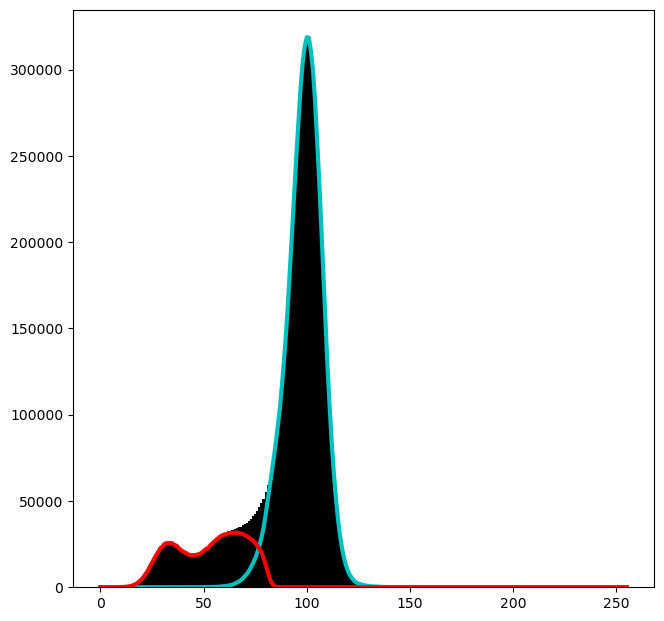

In [8]:
# Investigate how this segmentation unmixes volume histogram.
fig, ax = plt.subplots(figsize=(7.5, 7.5))

edges = np.arange(257)-0.5
centers = np.arange(256)
hist = np.histogram(vol.ravel(), edges)[0]
ax.bar(centers, hist, width=1, color='k')
ax.plot(centers, np.histogram(vol[bin_vol].ravel(), edges)[0], 'c', lw=3)
ax.plot(centers, np.histogram(vol[~bin_vol].ravel(), edges)[0], 'r', lw=3)
plt.show()




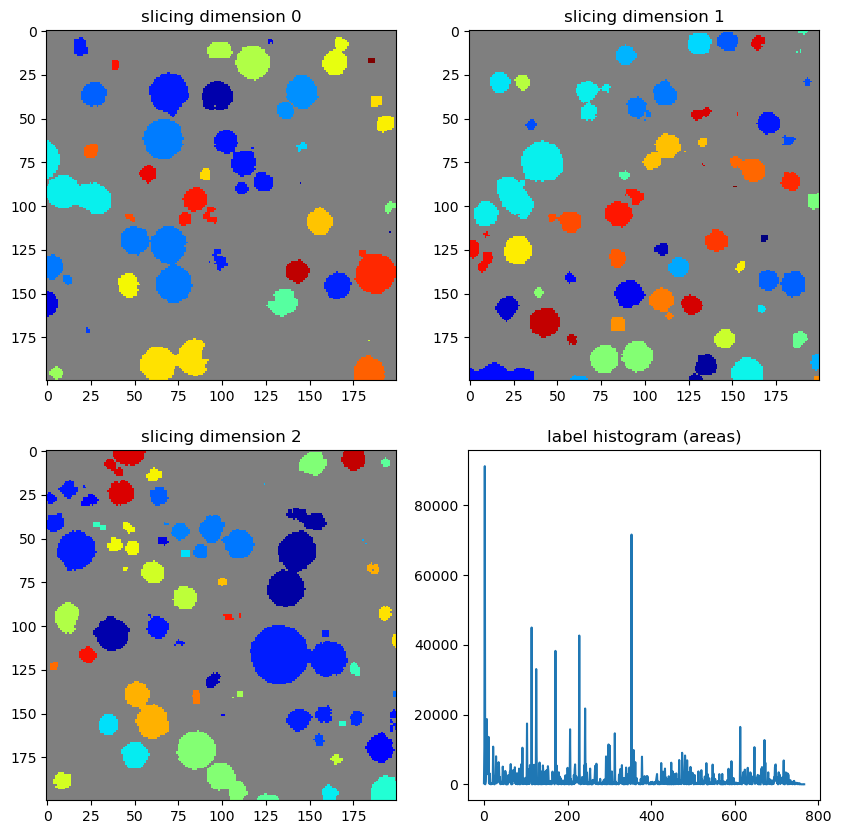

In [10]:
# Try connected component analysis.

labels = skimage.measure.label(~bin_vol)
nr_cc = labels.max()
cmap = random_colors(nr_cc)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
ax[0].imshow(labels[Z//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[0].set_title('slicing dimension 0')
ax[1].imshow(labels[:, Y//2, :], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[1].set_title('slicing dimension 1')
ax[2].imshow(labels[:, :, X//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[2].set_title('slicing dimension 2')
edges = np.arange(nr_cc + 1) + 0.5
centers = np.arange(nr_cc)
hist = np.histogram(labels[labels>0].ravel(), edges)[0]
ax[3].plot(centers, hist)
ax[3].set_title('label histogram (areas)')

plt.show()

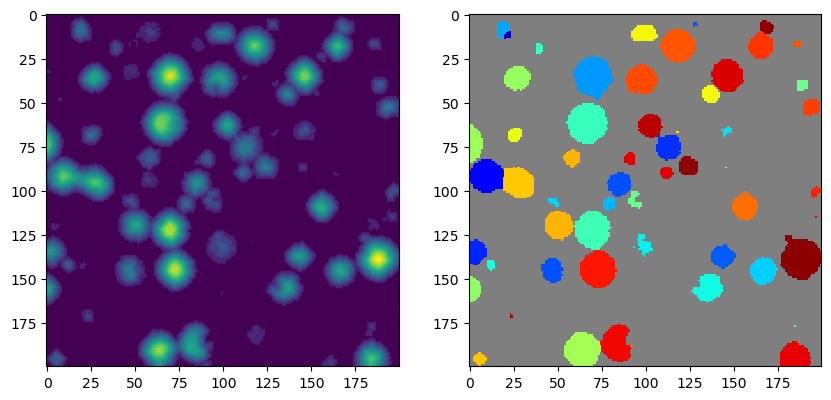

In [11]:
# Perform watershed transform to separate pores.

distance_field = scipy.ndimage.distance_transform_edt(~bin_vol)
distance_field = skimage.morphology.dilation(distance_field, skimage.morphology.ball(2))
labels = skimage.segmentation.watershed(-distance_field, mask=~bin_vol)

nr_cc = labels.max()
cmap = random_colors(nr_cc)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(distance_field[Z//2])
ax[1].imshow(labels[Z//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')

plt.show()


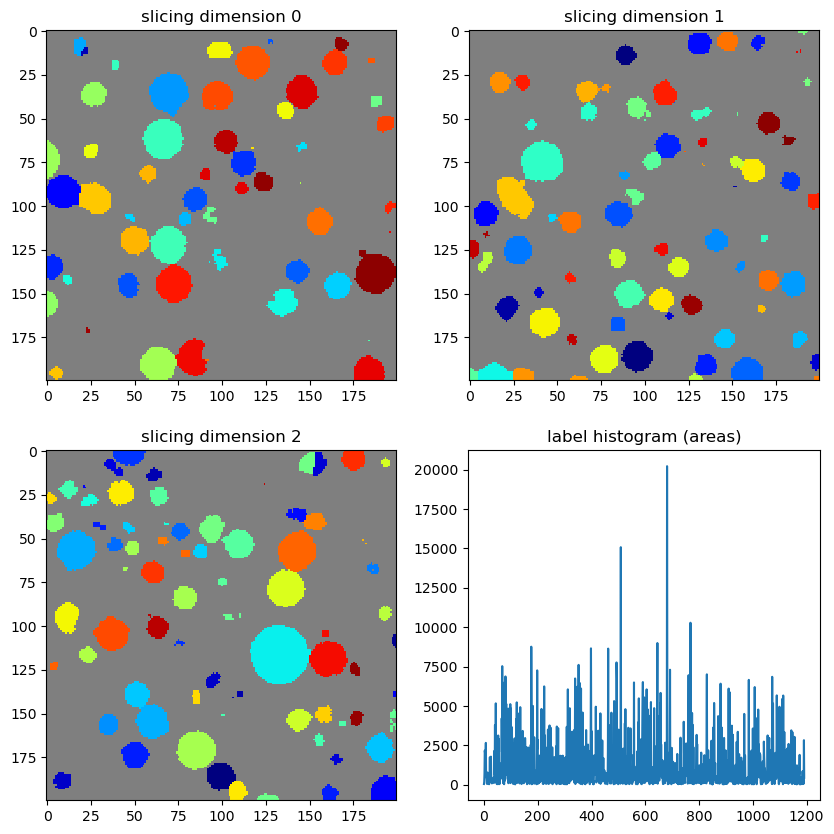

In [12]:
# Visualize output of connected component analysis on orhogonal slices.

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
ax[0].imshow(labels[Z//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[0].set_title('slicing dimension 0')
ax[1].imshow(labels[:, Y//2, :], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[1].set_title('slicing dimension 1')
ax[2].imshow(labels[:, :, X//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[2].set_title('slicing dimension 2')
edges = np.arange(nr_cc + 1) + 0.5
centers = np.arange(nr_cc)
hist = np.histogram(labels[labels>0].ravel(), edges)[0]
ax[3].plot(centers, hist)
ax[3].set_title('label histogram (areas)')

plt.show()

In [13]:
# Collect some statistics about connected components.

props = skimage.measure.regionprops(labels)
areas = [props[i].area for i in range(nr_cc)]
print(max(areas))


20217


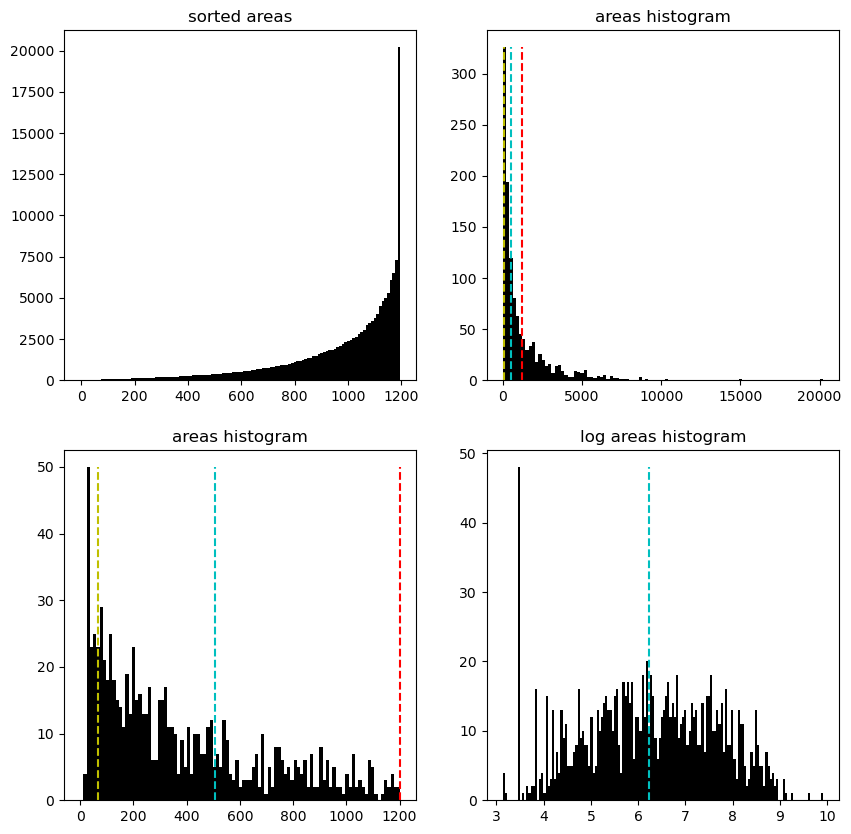

In [14]:
# Visualize the statistics.

areas = np.asanyarray(areas)
area_mean = areas.mean()
logareas = np.log(areas)
area_median = np.exp(logareas.mean())
area_mode = np.exp(logareas.mean() - logareas.std()**2) 

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

ax[0].bar(np.arange(len(areas))[len(areas):0:-10], 
          np.sort(areas)[len(areas):0:-10], width=10, color='k')
ax[0].set_title('sorted areas')

edges = np.linspace(0, areas.max(), 100)
centers = 0.5*(edges[:-1] + edges[1:])
hist = np.histogram(areas, edges)[0]
width = centers[1] - centers[0]
ax[1].bar(centers, hist, width=width, color='k')
ax[1].set_title('areas histogram')
ax[1].plot([area_mean]*2, [0, hist.max()], 'r--')
ax[1].plot([area_median]*2, [0, hist.max()], 'c--')
ax[1].plot([area_mode]*2, [0, hist.max()], 'y--')

edges = np.linspace(0, area_mean, 100)
centers = 0.5*(edges[:-1] + edges[1:])
hist = np.histogram(areas, edges)[0]
width = centers[1] - centers[0]
ax[2].bar(centers, hist, width=width, color='k')
ax[2].set_title('areas histogram')
ax[2].plot([area_mean]*2, [0, hist.max()], 'r--')
ax[2].plot([area_median]*2, [0, hist.max()], 'c--')
ax[2].plot([area_mode]*2, [0, hist.max()], 'y--')

hist, edges = np.histogram(logareas, 150)
centers = 0.5*(edges[:-1] + edges[1:])
width = centers[1] - centers[0]
ax[3].bar(centers, hist, width=width, color='k')
ax[3].plot([logareas.mean()]*2, [0, hist.max()], 'c--')
ax[3].set_title('log areas histogram')
plt.show()


In [15]:
print(f'Voxels per porosity {bin_vol.size/nr_cc:.0f}.')
print(f'Material density {100*bin_vol.sum()/bin_vol.size:.0f}%.')
print(f'Porosity area mean, median and mode {area_mean:.0f}, {area_median:.0f}, {area_mode:.0f}.')


Voxels per porosity 6711.
Material density 82%.
Porosity area mean, median and mode 1203, 508, 68.
